# Causal Inference Project

**Step 1**: Construct Directed Acyclic Graphs (DAG)

In [20]:
# Imports
import pandas as pd # type: ignore
import numpy as np # type: ignore

# viz
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
import networkx as nx

# utils
from utils import load_data

pd.set_option('display.max_columns', None)



![Alt Text](/Users/juanherrera/Desktop/causal-attribution-analysis/resources/other/data-schema.png)


### Loading Data

In [5]:
# Loading Data
data_dict = load_data()

olist_customers_df = data_dict['olist_customers_df']
olist_geolocation_df = data_dict['olist_geolocation_df']
olist_order_items_df = data_dict['olist_order_items_df']
olist_order_payments_df = data_dict['olist_order_payments_df']
olist_order_reviews_df = data_dict['olist_order_reviews_df']
olist_orders_df = data_dict['olist_orders_df']
olist_products_df = data_dict['olist_products_df']
olist_sellers_df = data_dict['olist_sellers_df']
product_category_name_translation_df = data_dict['product_category_name_translation_df']

In [11]:
print("Datasets & Columns")
for df_name, dataframe in data_dict.items():
    print("-"*100)
    print("-" * 10, df_name)

    for col in dataframe.columns:
        print(col)

Datasets & Columns
----------------------------------------------------------------------------------------------------
---------- olist_customers_df
customer_id
customer_unique_id
customer_zip_code_prefix
customer_city
customer_state
----------------------------------------------------------------------------------------------------
---------- olist_geolocation_df
geolocation_zip_code_prefix
geolocation_lat
geolocation_lng
geolocation_city
geolocation_state
----------------------------------------------------------------------------------------------------
---------- olist_order_items_df
order_id
order_item_id
product_id
seller_id
shipping_limit_date
price
freight_value
----------------------------------------------------------------------------------------------------
---------- olist_order_payments_df
order_id
payment_sequential
payment_type
payment_installments
payment_value
----------------------------------------------------------------------------------------------------
-------

In [12]:
# Merge into one dataset 

df = olist_orders_df.merge(olist_order_items_df, on='order_id', how='left')
df = df.merge(olist_order_payments_df, on='order_id', how='outer', validate='m:m')
df = df.merge(olist_order_reviews_df, on='order_id', how='outer')
df = df.merge(olist_products_df, on='product_id', how='outer')
df = df.merge(olist_customers_df, on='customer_id', how='outer')
df = df.merge(olist_sellers_df, on='seller_id', how='outer')

### Exploratory Data Analysis

In [35]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_purchase_date'] = df['order_purchase_timestamp'].dt.date

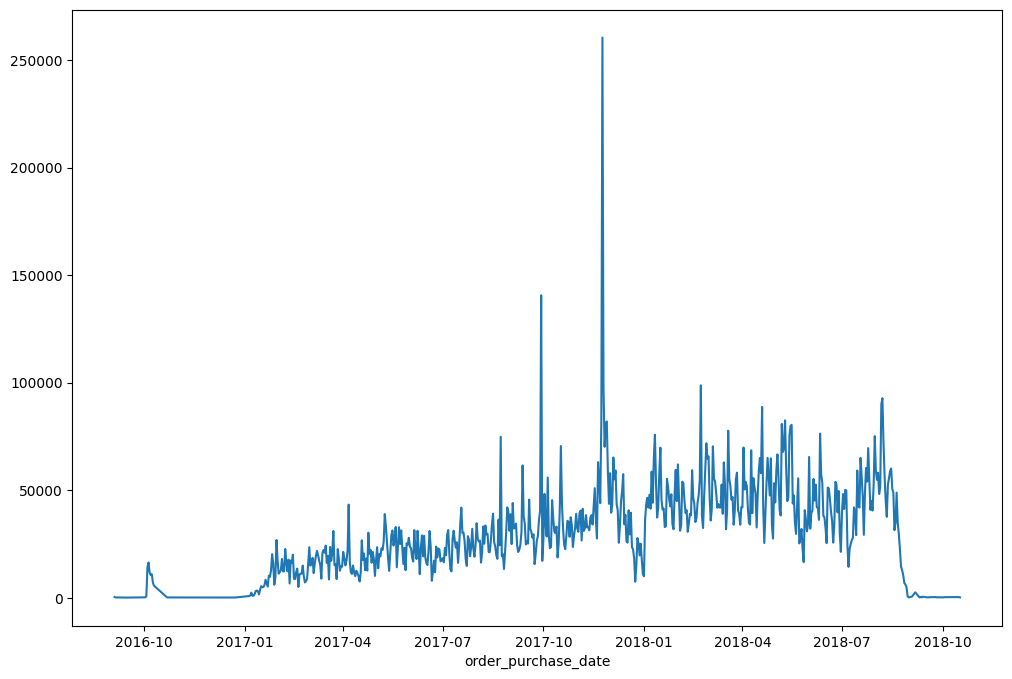

In [42]:
# payment_value = price + freight

plt.figure(figsize=(12,8))
df.groupby('order_purchase_date')['payment_value'].sum().plot();

### Directed Acyclic Graph (DAG)

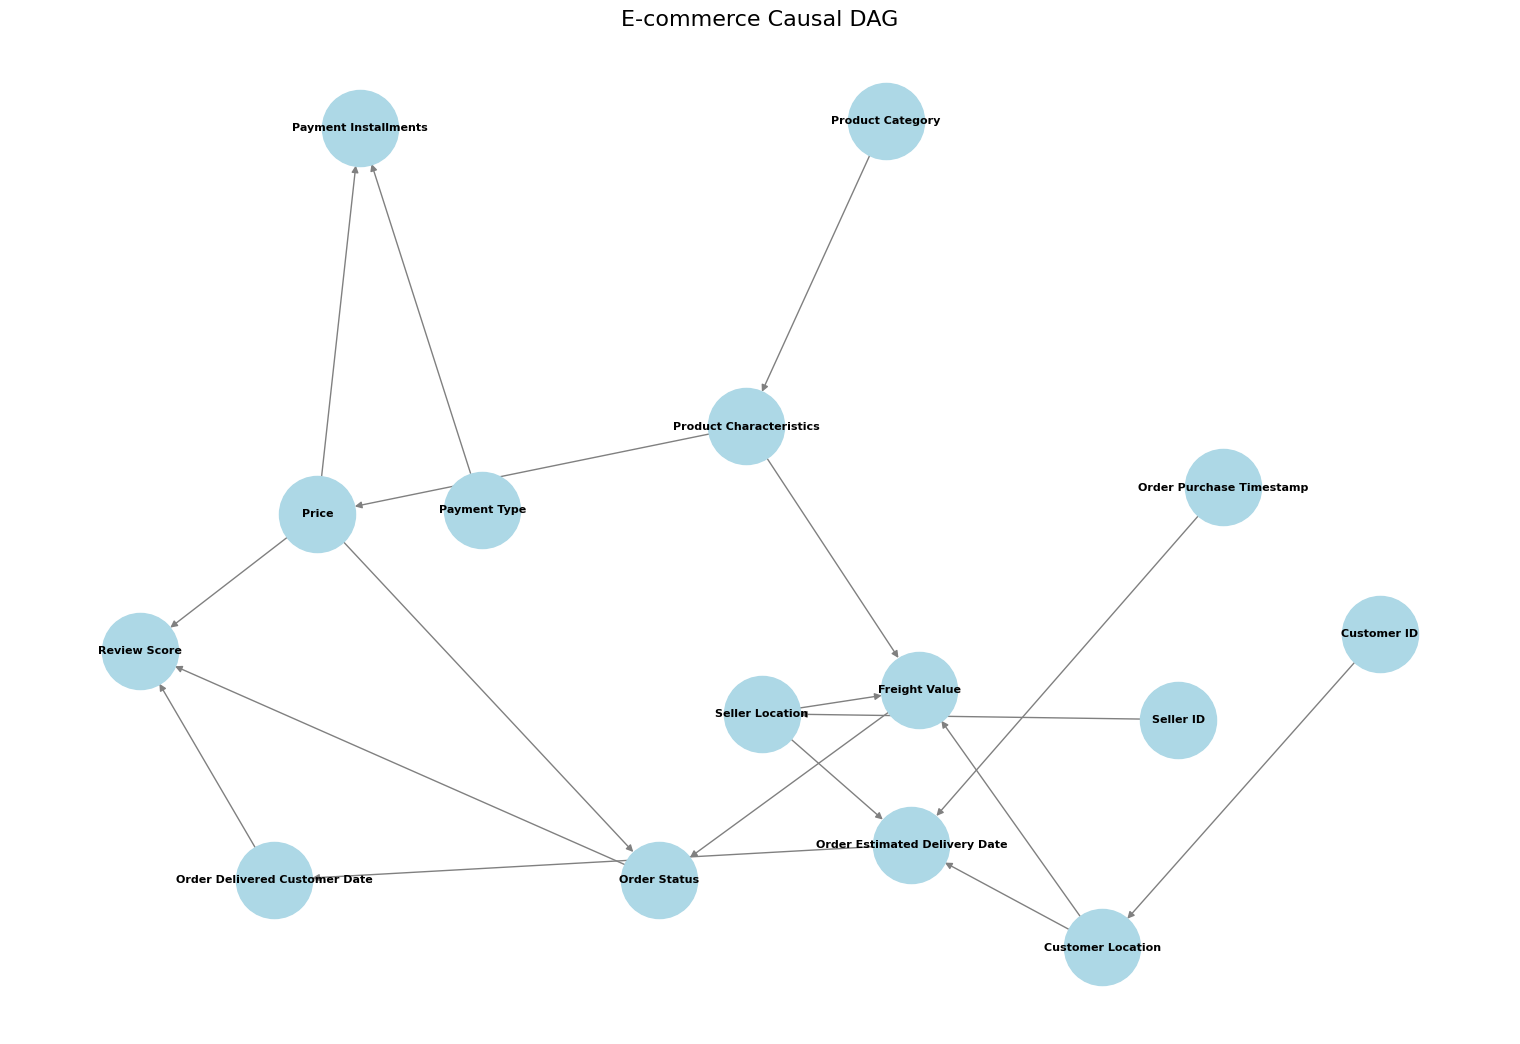

In [22]:
# Create a new directed graph
G = nx.DiGraph()

# Add nodes
nodes = [
    "Product Characteristics", "Price", "Freight Value", "Seller Location",
    "Customer Location", "Order Status", "Review Score", "Payment Type",
    "Payment Installments", "Order Purchase Timestamp", 
    "Order Estimated Delivery Date", "Order Delivered Customer Date",
    "Product Category", "Seller ID", "Customer ID"
]
G.add_nodes_from(nodes)

# Add edges (relationships)
edges = [
    ("Product Characteristics", "Price"),
    ("Product Characteristics", "Freight Value"),
    ("Seller Location", "Freight Value"),
    ("Customer Location", "Freight Value"),
    ("Price", "Order Status"),
    ("Freight Value", "Order Status"),
    ("Price", "Review Score"),
    ("Order Status", "Review Score"),
    ("Payment Type", "Payment Installments"),
    ("Price", "Payment Installments"),
    ("Order Purchase Timestamp", "Order Estimated Delivery Date"),
    ("Seller Location", "Order Estimated Delivery Date"),
    ("Customer Location", "Order Estimated Delivery Date"),
    ("Order Estimated Delivery Date", "Order Delivered Customer Date"),
    ("Order Delivered Customer Date", "Review Score"),
    ("Product Category", "Product Characteristics"),
    ("Seller ID", "Seller Location"),
    ("Customer ID", "Customer Location")
]
G.add_edges_from(edges)

# Set up the plot
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.9, iterations=50)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=8, font_weight='bold', 
        arrows=True, edge_color='gray')

# Add edge labels
edge_labels = {(u, v): '' for (u, v) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# Show the plot
plt.title("E-commerce Causal DAG", fontsize=16)
plt.axis('off')
plt.show()

In [40]:
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,order_purchase_date
0,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27 22:24:16,2017-09-29 15:53:03,2017-10-07 16:12:47,2017-10-30 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-12 22:24:16,895.0,21.02,1.0,credit_card,10.0,916.02,f6923b4d17e0f4e87b38cb26c758d3c6,5.0,NaN,NaN,2017-10-08 00:00:00,2017-10-11 21:42:45,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,3c7e305796add66698959fc7ad176f6b,87502,umuarama,PR,9080.0,santo andre,SP,2017-09-26
1,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18 23:56:20,2017-10-20 14:29:01,2017-10-27 16:46:05,2017-11-09 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-24 23:56:20,895.0,21.02,1.0,credit_card,8.0,916.02,2abb25fde5aafe9bc85d031dffb2f4ac,1.0,NaN,"Produto preto, reembalado na caixa de um branc...",2017-10-28 00:00:00,2017-10-28 14:32:42,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,9de5797cddb92598755a0f76383ddbbb,35490,entre rios de minas,MG,9080.0,santo andre,SP,2017-10-18
2,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12 13:49:22,2017-10-17 15:42:42,2017-10-24 20:17:44,2017-11-06 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-18 14:49:22,895.0,21.02,1.0,credit_card,4.0,916.02,799c3e3362ac0d09cfa1b39b51647490,5.0,NaN,NaN,2017-10-25 00:00:00,2017-10-25 23:15:15,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,9915eb9f74b6c11aaf04833f65b00e93,38600,paracatu,MG,9080.0,santo andre,SP,2017-10-12
3,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,1.0,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-09-08 08:25:50,99.0,33.08,1.0,credit_card,2.0,264.16,f402ea966112bd28646760b72d7f677f,5.0,NaN,NaN,2017-09-09 00:00:00,2017-09-09 20:51:47,ferramentas_jardim,36.0,450.0,1.0,9000.0,42.0,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710,sao goncalo,RJ,29156.0,cariacica,ES,2017-09-03
4,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,2.0,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-09-08 08:25:50,99.0,33.08,1.0,credit_card,2.0,264.16,f402ea966112bd28646760b72d7f677f,5.0,NaN,NaN,2017-09-09 00:00:00,2017-09-09 20:51:47,ferramentas_jardim,36.0,450.0,1.0,9000.0,42.0,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710,sao goncalo,RJ,29156.0,cariacica,ES,2017-09-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,87ae60ef8b08ae0e5f903cacb53a6904,fea4d57ed3a45455f89c25ef3dae8ee8,canceled,2018-09-11 16:45:54,NaN,NaN,NaN,2018-09-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,voucher,1.0,258.67,c9a026e699be6426bdc58731e6eec225,1.0,NaN,"Solicitei um produto e foi entregue outro, est...",2018-08-23 00:00:00,2018-08-26 12:40:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09687a7b7431a93b5c53b50ba779bf94,12010,taubate,SP,NaN,

In [ ]:
# ToDo:

# 1. Work on Improving DAG
# 2. Narrowing down questions. A couple of ideas below:
#